# Imports

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import sys, os
from glob import glob
import imageio
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

# Data Preprocessing


In [2]:
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/00278/SEMG_DB1.rar

--2023-05-05 14:24:06--  https://archive.ics.uci.edu/ml/machine-learning-databases/00278/SEMG_DB1.rar
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14440981 (14M) [application/x-httpd-php]
Saving to: ‘SEMG_DB1.rar’

SEMG_DB1.rar        100%[===================>]  13.77M  43.4MB/s    in 0.3s    

2023-05-05 14:24:06 (43.4 MB/s) - ‘SEMG_DB1.rar’ saved [14440981/14440981]



In [3]:
!unrar e  SEMG_DB1.rar


UNRAR 5.61 beta 1 freeware      Copyright (c) 1993-2018 Alexander Roshal


Extracting from SEMG_DB1.rar

Extracting  10Amar.log                                                     0%  OK 
Extracting  10Apie.log                                                     0%  1%  OK 
Extracting  10Asen.log                                                     1%  OK 
Extracting  11Amar.log                                                     1%  2%  OK 
Extracting  11Apie.log                                                     2%  OK 
Extracting  11Asen.log                                                     3%  OK 
Extracting  1Amar.log                                                      3%  OK 
Extracting  1Apie.log                                                      4%  OK 
Extracting  1Asen.log                                                      4%  OK 
Extracting  2Amar.log                             

In [4]:
!mkdir data
!mkdir data/A
!mkdir data/N
!mv [1-9]A*.txt data/A
!mv [1-9]N*.txt data/N
!mv 1[0-9]A*.txt data/A
!mv 1[0-9]N*.txt data/N

In [5]:
def read_folder(path): 
  folder_con = []
  file_name = []
  n = 1
  for file in os.listdir(path):
      if file.endswith(".txt"):
          file_path = f"{path}/{file}"
          df = pd.read_csv(file_path, sep='\t', skiprows=list(range(7)), header=None).dropna()
          
          if len(df.columns) == 6:
            df.drop(columns=df.columns[-2:], axis=1, inplace=True)
          if len(df.columns) == 5:
            df.drop(columns=df.columns[-1:], axis=1, inplace=True)
          
          folder_con.append(df)
          file_name.append(file_path)
          n = n + 1
          
  return folder_con, file_name

In [6]:
A_folder_con, A_name = read_folder('data/A')
N_folder_con, N_name = read_folder('data/N')
A_final_data = pd.concat(A_folder_con, ignore_index=True)
N_final_data = pd.concat(N_folder_con, ignore_index=True)
A_torch_data = torch.tensor(A_final_data.values)
N_torch_data = torch.tensor(N_final_data.values)

In [7]:
def image_creator(data, label, wid_len=256, stride=128):
  i = 0
  num = 0
  img_list = []
  while True:
    img = data[i: i+wid_len]
    i = i + stride
    num = num + 1 
    new = []
    new.append(img.reshape(1, wid_len, 4))
    new.append(label)
    img_list.append(new)
    if num == int(((len(data) - wid_len) / stride + 1)):
      break
  return img_list
  

In [8]:
N_list = image_creator(N_torch_data, label=0, wid_len=256, stride=128)
A_list = image_creator(A_torch_data, label=1, wid_len=256, stride=128)
data = A_list + N_list

In [9]:
class MyDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data_frame = data
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image = self.data_frame[idx][0]
        label = self.data_frame[idx][1]
        
        if self.transform:
            image = self.transform(image)

        return image, label

In [10]:
plt.imshow(data[0][0].squeeze(), cmap="gray")
plt.axis(False)
plt.show()

In [11]:
train, test = train_test_split(data, test_size=0.33, shuffle=True)

In [12]:
train_dataset = MyDataset(train)
test_dataset = MyDataset(test)


# Data loader
batch_size = 256
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)


test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)


# Network Implementation

In [13]:
class My_Net(nn.Module):
  def __init__(self, K=2):
    super(My_Net, self).__init__()

    self.conv1 = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding='same'),
        nn.ReLU(),
        nn.MaxPool2d((2, 2), stride=1),
        )
    self.conv2 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding='same'),
        nn.ReLU(),
        nn.MaxPool2d((2, 2), stride=(1, 1)),
        nn.Dropout2d(p=0.2)
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding='same'),
        nn.ReLU(),
        nn.MaxPool2d((2, 2), stride=(1, 1)),
        nn.Dropout2d(p=0.2)
    )

    
    self.fc1 = nn.Sequential(
        nn.Linear(256 * 253 * 1, K),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = x.view(-1, 256 * 253 * 1)
    x = self.fc1(x)
    
    return x

  

In [14]:
model = My_Net(K=2)


In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


My_Net(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.2, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.2, inplace=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=64768, out_features=2, bias=True)
    (1): Sigmoid()
  )
)

In [16]:
from torchsummary import summary
summary(model, (1, 256, 4))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 256, 4]             640
              ReLU-2           [-1, 64, 256, 4]               0
         MaxPool2d-3           [-1, 64, 255, 3]               0
            Conv2d-4          [-1, 128, 255, 3]          73,856
              ReLU-5          [-1, 128, 255, 3]               0
         MaxPool2d-6          [-1, 128, 254, 2]               0
         Dropout2d-7          [-1, 128, 254, 2]               0
            Conv2d-8          [-1, 256, 254, 2]         295,168
              ReLU-9          [-1, 256, 254, 2]               0
        MaxPool2d-10          [-1, 256, 253, 1]               0
        Dropout2d-11          [-1, 256, 253, 1]               0
           Linear-12                    [-1, 2]         129,538
          Sigmoid-13                    [-1, 2]               0
Total params: 499,202
Trainable params:

In [17]:
model.double()

My_Net(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.2, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.2, inplace=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=64768, out_features=2, bias=True)
    (1): Sigmoid()
  )
)

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [19]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  train_accs = np.zeros(epochs)
  test_losses = np.zeros(epochs)
  test_accs = np.zeros(epochs)

  for it in range(epochs):
    n_correct = 0.
    n_total = 0.
    model.train()
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()
      train_loss.append(loss.item())
      _, predictions = torch.max(outputs, 1)
      n_correct += (predictions == targets).sum().item()
      n_total += targets.shape[0]

    train_acc = n_correct / n_total
    train_loss = np.mean(train_loss)

    model.eval()
    with torch.no_grad():
      test_loss = []
      n_correct = 0.
      n_total = 0.
      for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss.append(loss.item())
        _, predictions = torch.max(outputs, 1)
        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]

      test_loss = np.mean(test_loss)
      test_acc = n_correct / n_total

      train_losses[it] = train_loss
      test_losses[it] = test_loss
      train_accs[it] = train_acc
      test_accs[it] = test_acc


      dt = datetime.now() - t0
      print(f"Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}, Duration:{dt}")

  return train_losses, test_losses, train_accs, test_accs



# Model Train and Resualts

In [20]:
train_losses, test_losses, train_accs, test_accs = batch_gd(
    model, criterion, optimizer, train_loader, test_loader, epochs=10
)

Epoch 1/10, Train Loss: 0.6423,       Test Loss: 0.6358, Duration:0:01:09.482619
Epoch 2/10, Train Loss: 0.6306,       Test Loss: 0.6373, Duration:0:01:09.544318
Epoch 3/10, Train Loss: 0.6299,       Test Loss: 0.6316, Duration:0:01:09.392356
Epoch 4/10, Train Loss: 0.6216,       Test Loss: 0.6329, Duration:0:01:09.314260
Epoch 5/10, Train Loss: 0.6117,       Test Loss: 0.6275, Duration:0:01:09.251264
Epoch 6/10, Train Loss: 0.6165,       Test Loss: 0.6283, Duration:0:01:09.233489
Epoch 7/10, Train Loss: 0.6115,       Test Loss: 0.6179, Duration:0:01:09.275077
Epoch 8/10, Train Loss: 0.6033,       Test Loss: 0.6021, Duration:0:01:09.235568
Epoch 9/10, Train Loss: 0.5919,       Test Loss: 0.5941, Duration:0:01:09.229018
Epoch 10/10, Train Loss: 0.5845,       Test Loss: 0.5897, Duration:0:01:09.221550


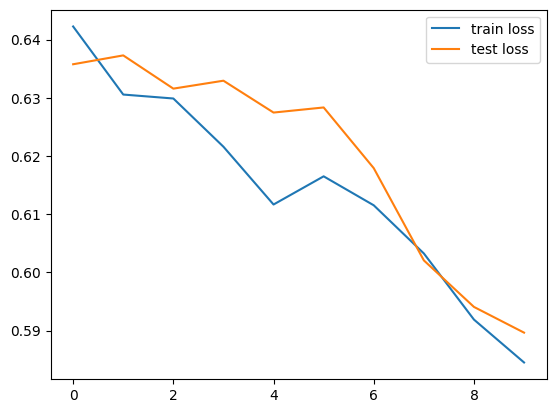

In [21]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [22]:
model.eval()
with torch.no_grad():
  n_correct = 0.
  n_total = 0.
  for inputs, targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

  train_acc = n_correct / n_total

  n_correct = 0.
  n_total = 0.
  for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

  test_acc = n_correct / n_total
  print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.7040, Test acc: 0.6961


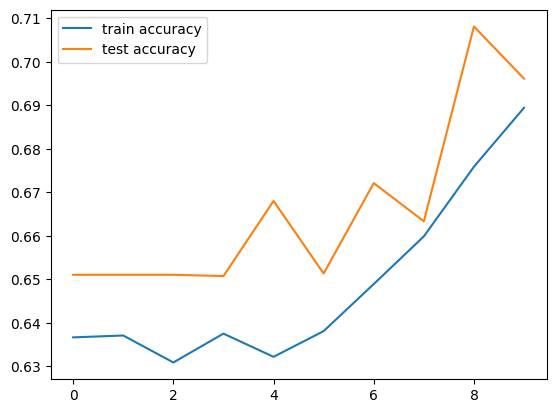

In [23]:
plt.plot(train_accs, label='train accuracy')
plt.plot(test_accs, label='test accuracy')
plt.legend()
plt.show()